# IEEE-CIS Fraud Detection: EDA and models

Kaggle [IEEE-CIS Fraud Detection][kaggle] において、
[EDA and models][artgor] をベースに利用しています。
多くの場所は写経となっています。


[kaggle]: https://www.kaggle.com/c/ieee-fraud-detection/
[artgor]: https://www.kaggle.com/artgor/eda-and-models

## Add packages

In [0]:
!pip install kaggle

## Import

In [0]:
# default packages
import gc
import logging
import pathlib
import pprint
import time
import typing as t

In [0]:
# third party packages
import google.colab.drive as drive
import IPython.display as display
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import tqdm.notebook as tqdm

In [0]:
# auto reload
%load_ext autoreload
%autoreload 2

In [0]:
# logger
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [0]:
# graph settings
sns.set()

## Directory structure

In [0]:
data_dir = pathlib.Path("data")
raw_dir = data_dir.joinpath("raw")
processed_dir = data_dir.joinpath("processed")

data_dir.mkdir(exist_ok=True)
raw_dir.mkdir(exist_ok=True)
processed_dir.mkdir(exist_ok=True)

## Mount google drive

In [0]:
def mount_gdrive() -> pathlib.Path:
    """Google Drive をマウントし、必要なディレクトリへのシンボリックリンクを設定する."""
    gdrive_base = pathlib.Path("/content/drive")
    gdrive_cache = gdrive_base.joinpath("My Drive/storeItemDemandForecastingChallenge")
    gdrive_kaggle = gdrive_base.joinpath("My Drive/kaggle")

    kaggle_dir = pathlib.Path("./kaggle")
    cache_dir = pathlib.Path("./cache")

    if gdrive_base.exists() is False:
        drive.mount(str(gdrive_base))
    if cache_dir.exists() is False:
        !ln -s "$gdrive_cache" "$cache_dir"
    if kaggle_dir.exists() is False:
        !ln -s "$gdrive_kaggle" "$kaggle_dir"

    return cache_dir, kaggle_dir


cache_dir, kaggle_dir = mount_gdrive()

ln: failed to create symbolic link 'cache': File exists


## Enable kaggle API

In [0]:
def activate_kaggle_api(gdrive_kaggle: pathlib.Path) -> None:
    """Kaggle API を有効化するための token を Google Drive からコピーする."""
    kaggle_file = "kaggle.json"
    gdrive_kaggle_json = gdrive_kaggle.joinpath(kaggle_file)
    local_kaggle_dir = pathlib.Path("/root/.kaggle")
    local_kaggle_json = local_kaggle_dir.joinpath(kaggle_file)

    local_kaggle_dir.mkdir(exist_ok=True)
    !cp "$gdrive_kaggle_json" "$local_kaggle_json"
    !chmod 600 "$local_kaggle_json"


activate_kaggle_api(kaggle_dir)

## Load dataset

In [0]:
competition_name = "ieee-fraud-detection"
!kaggle competitions download -c "$competition_name" -p "$raw_dir"

train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
def load_dataset() -> t.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Notes:
        - id-xx の部分が train と test で異なるため、一致するように修正を行う。
    """
    train_identity = pd.read_csv(raw_dir.joinpath("train_identity.csv.zip"))
    train_transaction = pd.read_csv(raw_dir.joinpath("train_transaction.csv.zip"))
    
    test_identity = pd.read_csv(raw_dir.joinpath("test_identity.csv.zip"))
    test_transaction = pd.read_csv(raw_dir.joinpath("test_transaction.csv.zip"))
    
    sub = pd.read_csv(raw_dir.joinpath("sample_submission.csv.zip"))

    train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")
    train.columns = [name.replace("-", "_") for name in train.columns]

    test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")
    test.columns = [name.replace("-", "_") for name in test.columns]

    return train, test, sub


df_train_org, df_test_org, df_sub_org = load_dataset()

## Show dataset info

In [0]:
# show train dataset
display.display(df_train_org.head())
display.display(df_train_org.tail())
logger.info(df_train_org.info())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [0]:
# show test dataset
display.display(df_test_org.head())
display.display(df_test_org.tail())
logger.info(df_test_org.info())

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,-45.0,266704.0,NaN,NaN,-3.0,-10.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506690,4170239,34214345,24.346,C,5713,168.0,144.0,visa,147.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,29.958332,0.958333,0.0,...,-10.0,692090.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,NaN,266.0,127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,samsung browser 8.2,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.6+ GB


In [0]:
# show submission dataset
display.display(df_sub_org.head())
display.display(df_sub_org.tail())
logger.info(df_sub_org.info())

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


,TransactionID,isFraud
506686,4170235,0.5
506687,4170236,0.5
506688,4170237,0.5
506689,4170238,0.5
506690,4170239,0.5


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int64  
 1   isFraud        506691 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.7 MB


In [0]:
def show_column_set(df_train: pd.DataFrame, df_test: pd.DataFrame) -> None:
    cols_train = df_train.columns
    cols_test = df_test.columns

    cols_sub1 = set(cols_train) - set(cols_test)
    cols_sub2 = set(cols_test) - set(cols_train)

    logger.info(pprint.pformat(cols_sub1))
    logger.info(pprint.pformat(cols_sub2))


show_column_set(df_train_org, df_test_org)

INFO:__main__:{'isFraud'}
INFO:__main__:set()


In [0]:
def missing_values(df: pd.DataFrame) -> None:
    columns = df.isnull().any().sum()
    logger.info(f"There are {columns} columns in dataset with missing values.")

missing_values(df_train_org)
missing_values(df_test_org)

INFO:__main__:There are 414 columns in dataset with missing values.
INFO:__main__:There are 385 columns in dataset with missing values.


In [0]:
def one_value_columns(df: pd.DataFrame) -> None:
    columns = [name for name in df.columns if len(df[name].unique()) < 2]
    logger.info(f"There are {len(columns)} columns in dataset withone uqnie values.")
    logger.info(f"unique columns: {columns}")


one_value_columns(df_train_org)
one_value_columns(df_test_org)

INFO:__main__:There are 0 columns in dataset withone uqnie values.
INFO:__main__:unique columns: []
INFO:__main__:There are 1 columns in dataset withone uqnie values.
INFO:__main__:unique columns: ['V107']


## Data Exploration

### Categorical column: "id_"

In [0]:
def show_categorical(series: pd.Series, title: str) -> None:
    counts = series.value_counts(dropna=True, normalize=False)
    if len(counts) > 200:
        logger.info(
            f"{title} has many unique values."
            f" number of unique values is {len(counts)}."
            "  skip."
        )
        return

    top_num = 20
    if len(counts) > top_num:
        counts = counts.sort_values(ascending=False).iloc[:top_num]

    plt.figure(figsize=(16, 3))
    plt.bar(counts.index, counts, color="b", align="center")
    plt.title(f"Top {top_num} {title}")
    plt.xticks(rotation="vertical")
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    counts = series.value_counts(dropna=False, normalize=True)
    logger.info(f"unique values num in train: {len(counts)}")
    logger.info(counts.head())

INFO:__main__:test dataset has no id_ column: True


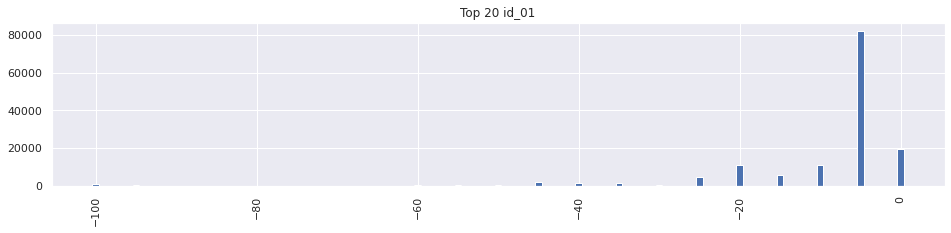

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:__main__:unique values num in train: 78
INFO:__main__: NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64
INFO:__main__:id_02 has many unique values. number of unique values is 115655.  skip.


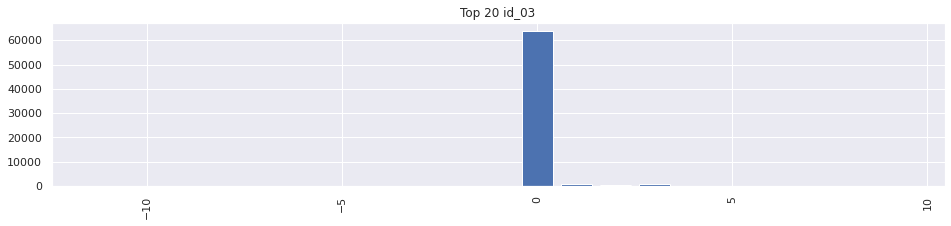

INFO:__main__:unique values num in train: 25
INFO:__main__:NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64


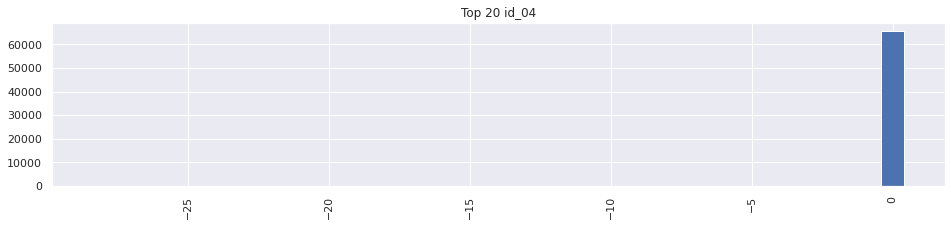

INFO:__main__:unique values num in train: 16
INFO:__main__: NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64


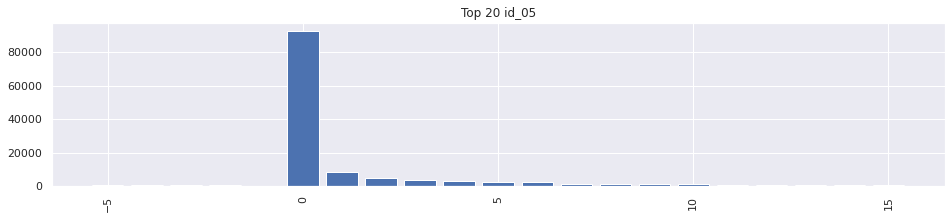

INFO:__main__:unique values num in train: 94
INFO:__main__:NaN    0.768238
0.0    0.157048
1.0    0.014043
2.0    0.008360
3.0    0.006526
Name: id_05, dtype: float64


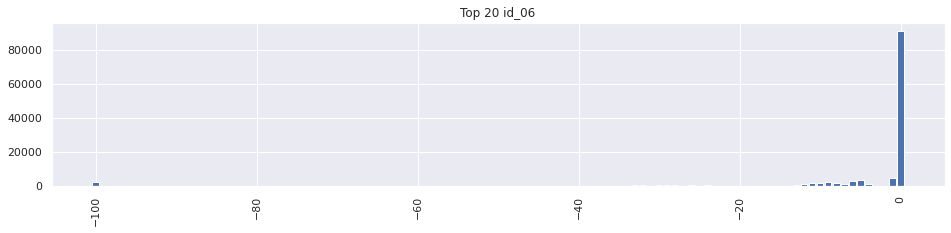

INFO:__main__:unique values num in train: 102
INFO:__main__: NaN    0.768238
 0.0    0.154647
-1.0    0.007937
-5.0    0.006518
-6.0    0.005515
Name: id_06, dtype: float64


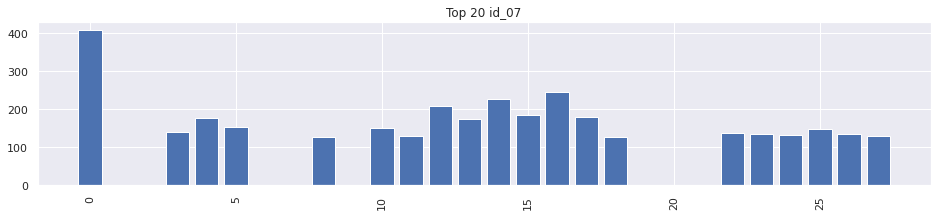

INFO:__main__:unique values num in train: 85
INFO:__main__:NaN     0.991271
0.0     0.000693
16.0    0.000415
14.0    0.000386
12.0    0.000352
Name: id_07, dtype: float64


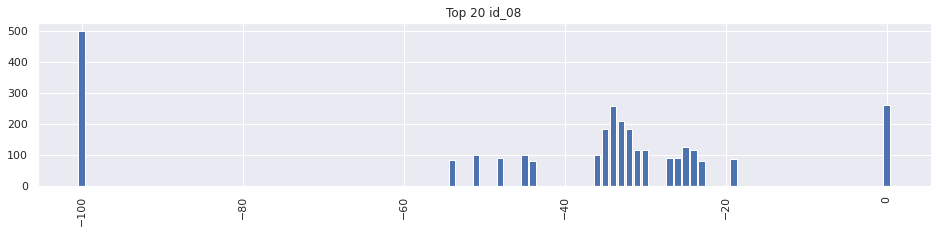

INFO:__main__:unique values num in train: 95
INFO:__main__: NaN      0.991271
-100.0    0.000847
 0.0      0.000442
-34.0     0.000435
-33.0     0.000354
Name: id_08, dtype: float64


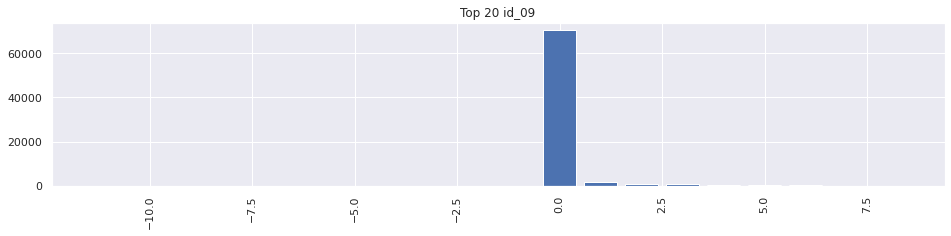

INFO:__main__:unique values num in train: 47
INFO:__main__:NaN    0.873123
0.0    0.119176
1.0    0.002736
3.0    0.001636
2.0    0.001309
Name: id_09, dtype: float64


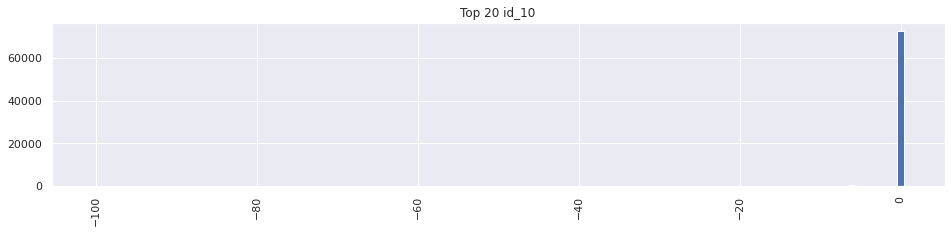

INFO:__main__:unique values num in train: 63
INFO:__main__: NaN    0.873123
 0.0    0.123411
-6.0    0.000500
-5.0    0.000418
-1.0    0.000339
Name: id_10, dtype: float64
INFO:__main__:id_11 has many unique values. number of unique values is 365.  skip.


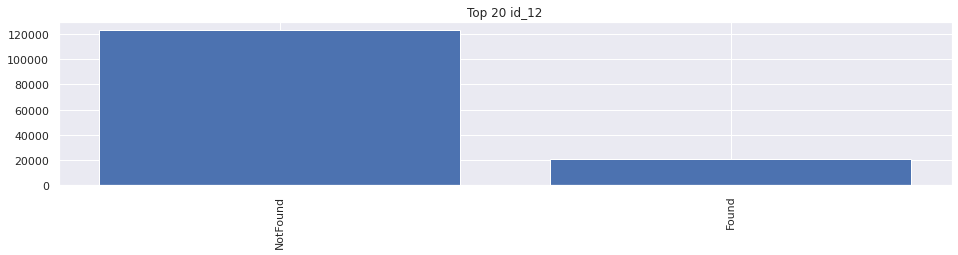

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN         0.755761
NotFound    0.208326
Found       0.035913
Name: id_12, dtype: float64


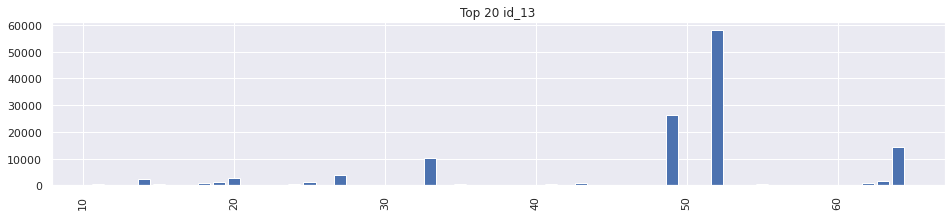

INFO:__main__:unique values num in train: 55
INFO:__main__:NaN     0.784401
52.0    0.098383
49.0    0.044646
64.0    0.024434
33.0    0.017015
Name: id_13, dtype: float64


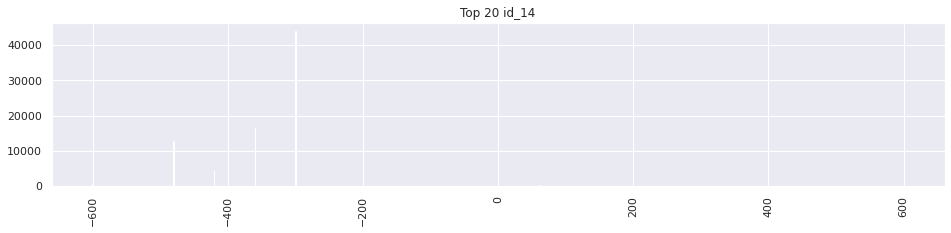

INFO:__main__:unique values num in train: 26
INFO:__main__: NaN      0.864456
-300.0    0.074713
-360.0    0.028213
-480.0    0.021829
-420.0    0.007691
Name: id_14, dtype: float64


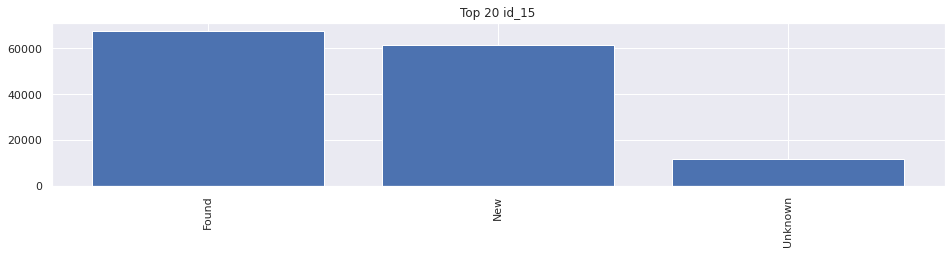

INFO:__main__:unique values num in train: 4
INFO:__main__:NaN        0.761261
Found      0.114688
New        0.104332
Unknown    0.019719
Name: id_15, dtype: float64


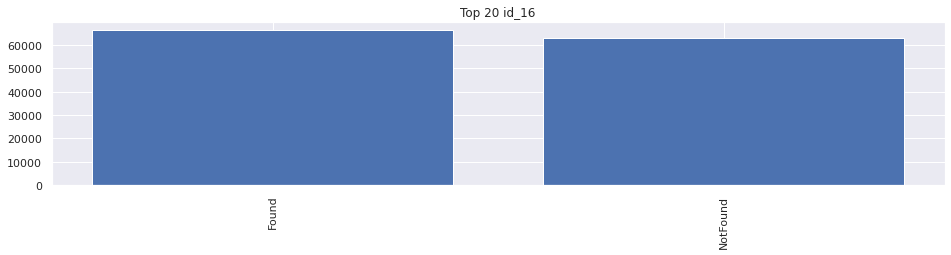

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN         0.780980
Found       0.112311
NotFound    0.106709
Name: id_16, dtype: float64


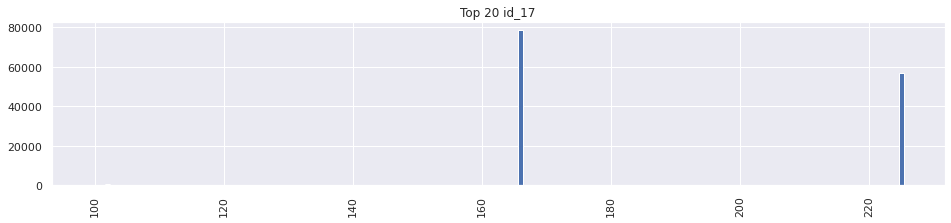

INFO:__main__:unique values num in train: 105
INFO:__main__:NaN      0.763997
166.0    0.133151
225.0    0.096468
102.0    0.001167
159.0    0.000596
Name: id_17, dtype: float64


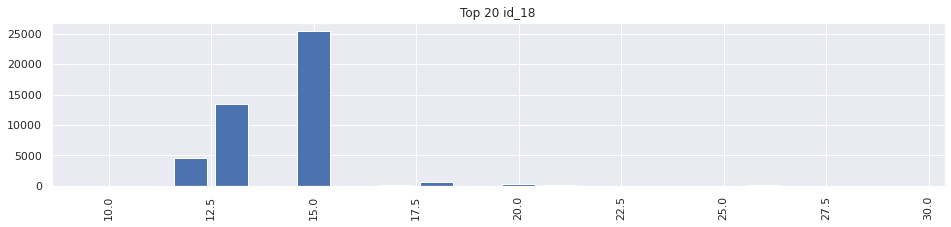

INFO:__main__:unique values num in train: 19
INFO:__main__:NaN     0.923607
15.0    0.043162
13.0    0.022757
12.0    0.007884
18.0    0.001101
Name: id_18, dtype: float64
INFO:__main__:id_19 has many unique values. number of unique values is 522.  skip.
INFO:__main__:id_20 has many unique values. number of unique values is 394.  skip.
INFO:__main__:id_21 has many unique values. number of unique values is 490.  skip.


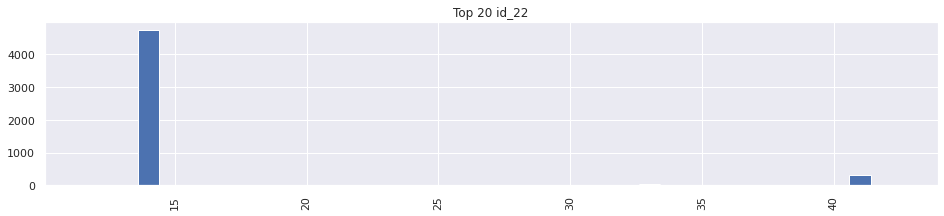

INFO:__main__:unique values num in train: 26
INFO:__main__:NaN     0.991247
14.0    0.008020
41.0    0.000544
33.0    0.000064
21.0    0.000012
Name: id_22, dtype: float64


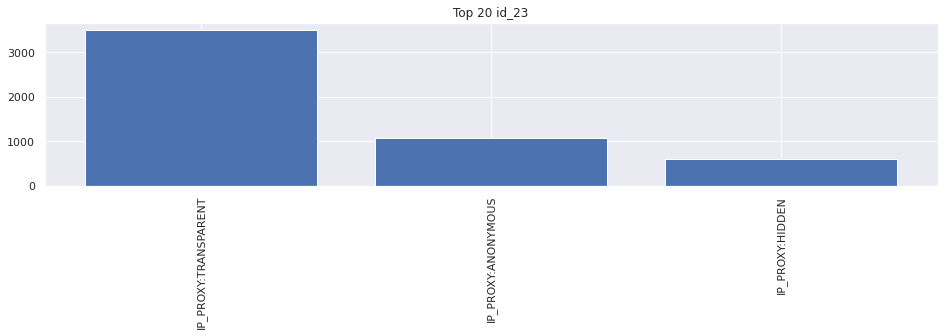

INFO:__main__:unique values num in train: 4
INFO:__main__:NaN                     0.991247
IP_PROXY:TRANSPARENT    0.005908
IP_PROXY:ANONYMOUS      0.001814
IP_PROXY:HIDDEN         0.001031
Name: id_23, dtype: float64


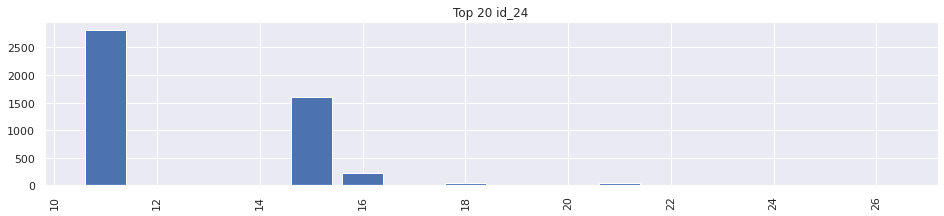

INFO:__main__:unique values num in train: 13
INFO:__main__:NaN     0.991962
11.0    0.004770
15.0    0.002699
16.0    0.000373
18.0    0.000063
Name: id_24, dtype: float64
INFO:__main__:id_25 has many unique values. number of unique values is 341.  skip.


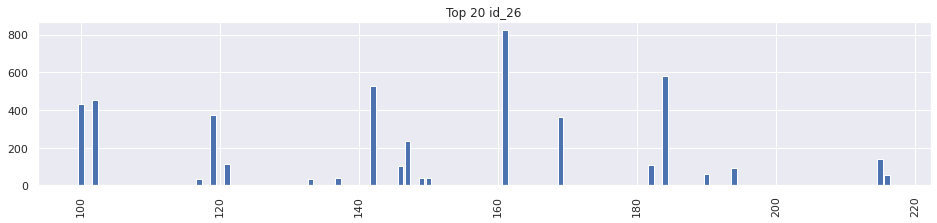

INFO:__main__:unique values num in train: 96
INFO:__main__:NaN      0.991257
161.0    0.001395
184.0    0.000986
142.0    0.000894
102.0    0.000764
Name: id_26, dtype: float64


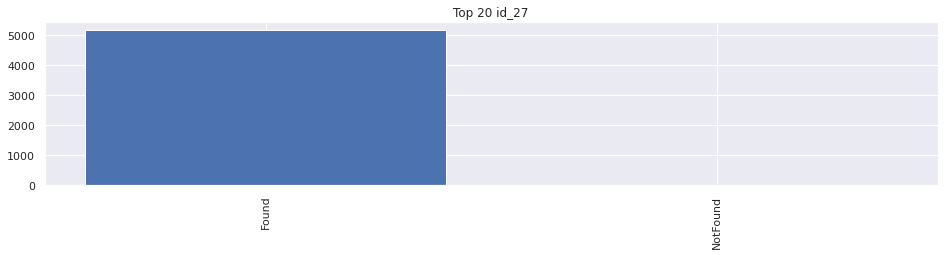

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN         0.991247
Found       0.008729
NotFound    0.000024
Name: id_27, dtype: float64


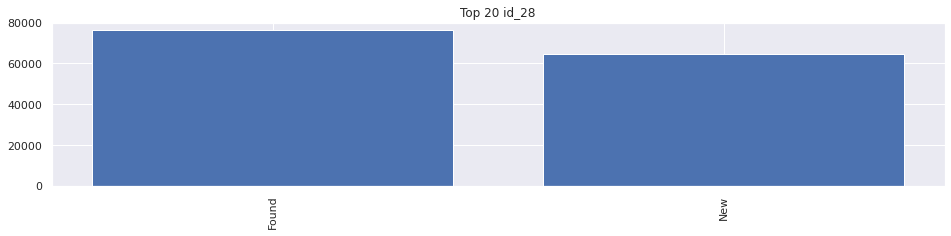

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN      0.761273
Found    0.129089
New      0.109639
Name: id_28, dtype: float64


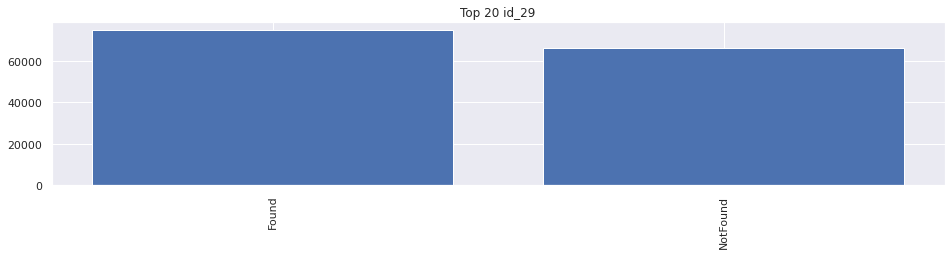

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN         0.761273
Found       0.126877
NotFound    0.111850
Name: id_29, dtype: float64


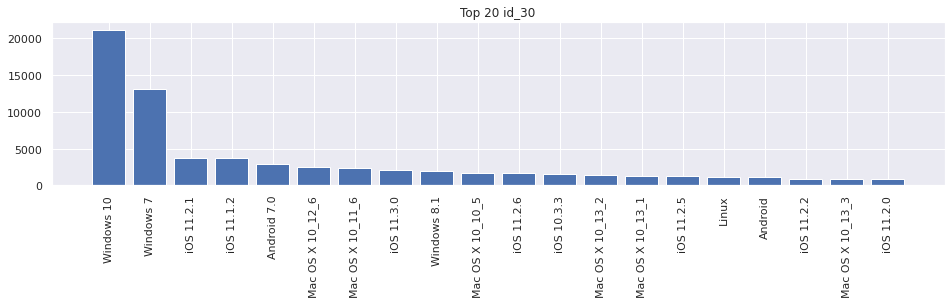

INFO:__main__:unique values num in train: 76
INFO:__main__:NaN           0.868654
Windows 10    0.035823
Windows 7     0.022200
iOS 11.2.1    0.006303
iOS 11.1.2    0.006264
Name: id_30, dtype: float64


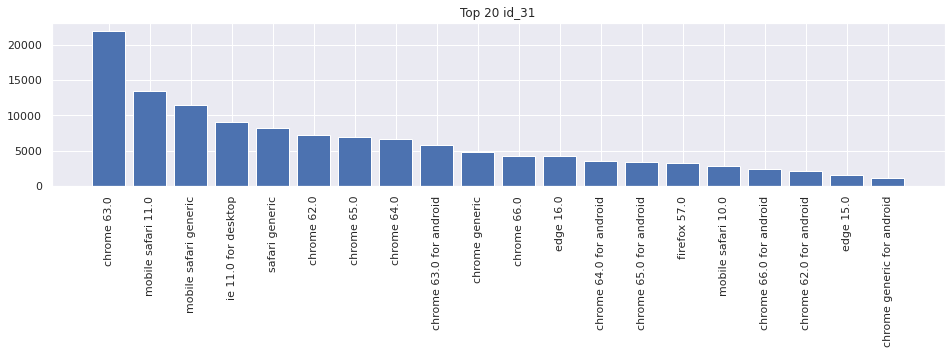

INFO:__main__:unique values num in train: 131
INFO:__main__:NaN                      0.762451
chrome 63.0              0.037254
mobile safari 11.0       0.022730
mobile safari generic    0.019430
ie 11.0 for desktop      0.015291
Name: id_31, dtype: float64


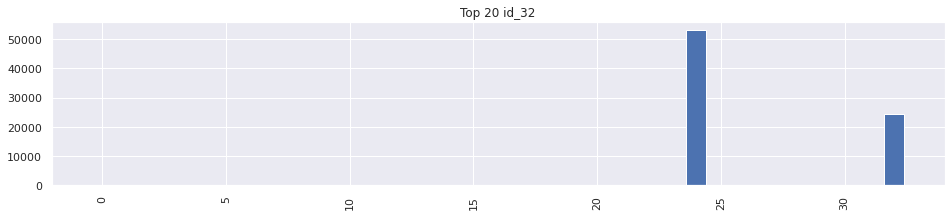

INFO:__main__:unique values num in train: 5
INFO:__main__:NaN     0.868619
24.0    0.089869
32.0    0.041366
16.0    0.000137
0.0     0.000010
Name: id_32, dtype: float64
INFO:__main__:id_33 has many unique values. number of unique values is 260.  skip.


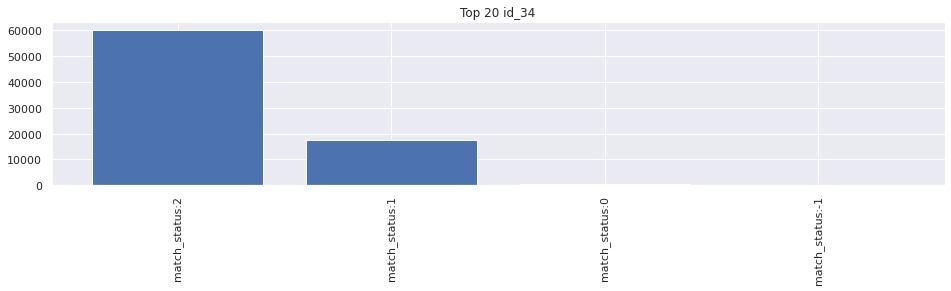

INFO:__main__:unique values num in train: 5
INFO:__main__:NaN                0.868248
match_status:2     0.101621
match_status:1     0.029424
match_status:0     0.000703
match_status:-1    0.000005
Name: id_34, dtype: float64


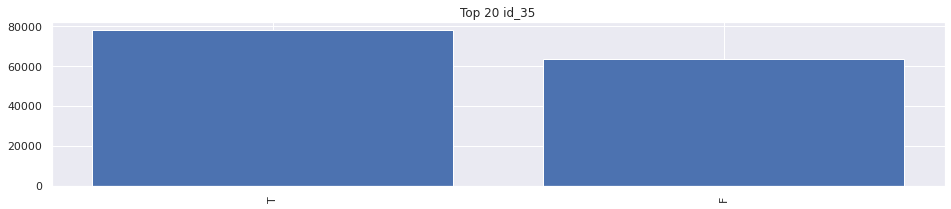

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN    0.761261
T      0.131768
F      0.106972
Name: id_35, dtype: float64


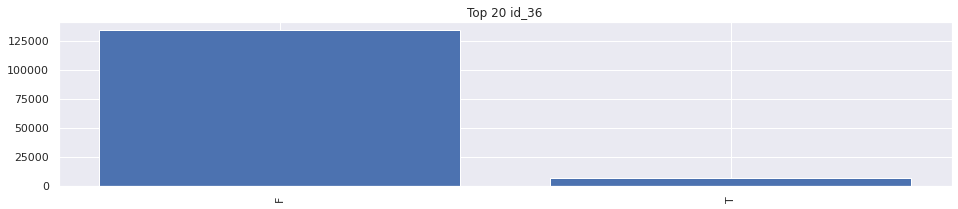

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN    0.761261
F      0.227023
T      0.011716
Name: id_36, dtype: float64


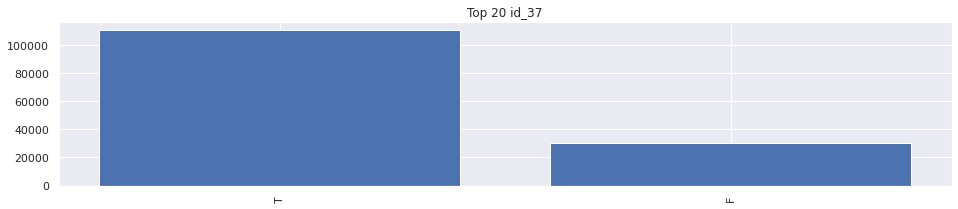

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN    0.761261
T      0.187036
F      0.051704
Name: id_37, dtype: float64


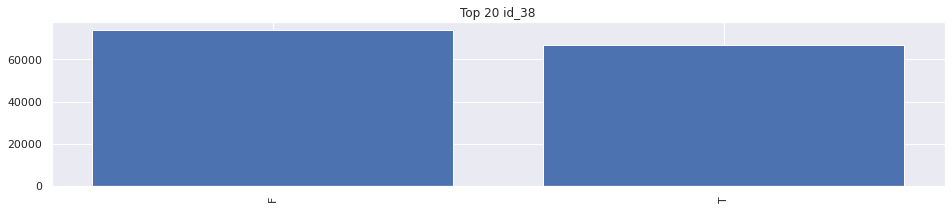

INFO:__main__:unique values num in train: 3
INFO:__main__:NaN    0.761261
F      0.125177
T      0.113562
Name: id_38, dtype: float64


In [0]:
logger.info(f"test dataset has no id_ column: {df_test_org.columns.str.contains('id_').any()}")

for name in df_train_org.columns[df_train_org.columns.str.contains("id_")]:
    show_categorical(df_train_org[name], name)

### Categorical column: "card"

In [0]:
def show_categorical_with_test(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    title: str
) -> None:
    counts_train = df_train[title].value_counts(dropna=True, normalize=False)
    if len(counts_train) > 200:
        logger.info(
            f"{title} has many unique values."
            f" number of unique values is {len(counts_train)}."
            "  skip."
        )
        return

    counts_test = pd.Series()
    use_test = title in df_test.columns
    if use_test:
        counts_test = df_test[title].value_counts(dropna=True, normalize=False)

    top_num = 20
    if len(counts_train) > top_num:
        counts_train = counts_train.sort_values(ascending=False).iloc[:top_num]
    if len(counts_test) > top_num:
        counts_test = counts_test.sort_values(ascending=False).iloc[:top_num]

    df = pd.DataFrame({
        "train": counts_train,
        "test": counts_test,
    })

    df.plot.bar(rot=90, figsize=(16, 3))
    plt.title(title)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()

    counts_train = df_train[title].value_counts(dropna=False, normalize=True)
    logger.info(f"unique values num in train: {len(counts_train)}")
    display.display(counts_test.to_frame().T.head())

    if use_test:
        counts_test = df_test[title].value_counts(dropna=False, normalize=True)
        logger.info(f"unique values num in test: {len(counts_test)}")
        display.display(counts_test.to_frame().T.head())

INFO:__main__:does test dataset have card column? True
INFO:__main__:card1 has many unique values. number of unique values is 13553.  skip.
INFO:__main__:card2 has many unique values. number of unique values is 500.  skip.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


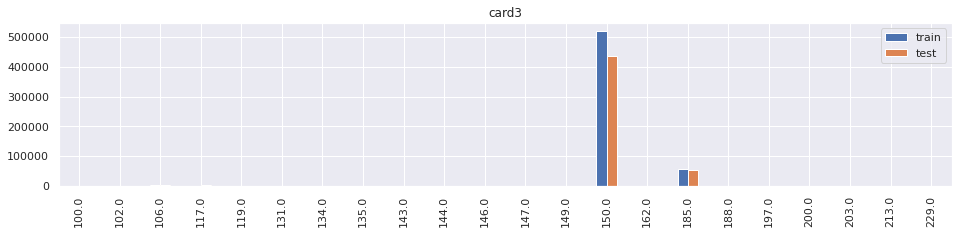

INFO:__main__:unique values num in train: 115


,150.0,185.0,106.0,117.0,144.0,146.0,143.0,102.0,162.0,147.0,203.0,119.0,213.0,100.0,188.0,134.0,131.0,229.0,149.0,197.0
card3,435558,53614,1972,1879,1381,1218,771,738,700,478,346,341,333,327,327,274,219,216,210,189


INFO:__main__:unique values num in test: 116


,150.0,185.0,NaN,106.0,117.0,144.0,146.0,143.0,102.0,162.0,147.0,203.0,119.0,213.0,100.0,188.0,134.0,131.0,229.0,149.0,197.0,195.0,210.0,200.0,215.0,121.0,223.0,135.0,159.0,138.0,141.0,137.0,148.0,199.0,190.0,194.0,198.0,214.0,166.0,133.0,...,126.0,113.0,218.0,207.0,145.0,151.0,140.0,128.0,163.0,184.0,124.0,108.0,216.0,202.0,118.0,115.0,165.0,187.0,112.0,176.0,169.0,178.0,219.0,125.0,104.0,171.0,154.0,116.0,232.0,173.0,110.0,181.0,103.0,201.0,196.0,230.0,174.0,175.0,183.0,186.0
card3,0.859613,0.105812,0.005925,0.003892,0.003708,0.002726,0.002404,0.001522,0.001457,0.001382,0.000943,0.000683,0.000673,0.000657,0.000645,0.000645,0.000541,0.000432,0.000426,0.000414,0.000373,0.000328,0.000302,0.00028,0.000274,0.000253,0.000249,0.000223,0.000217,0.000215,0.000191,0.000138,0.000124,0.000114,0.000107,0.000107,0.000105,0.000103,0.000097,0.000095,...,0.000008,0.000008,0.000008,0.000008,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


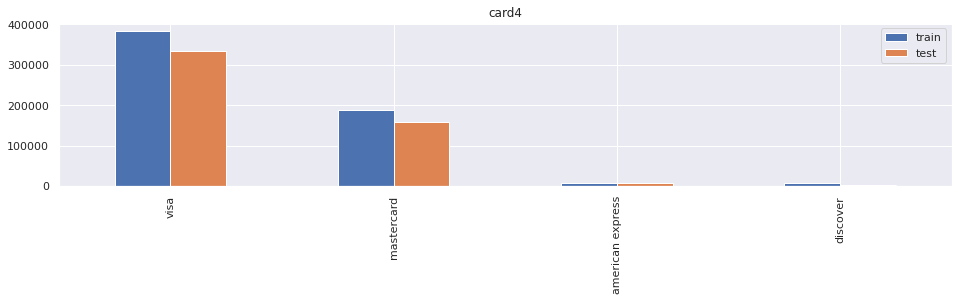

INFO:__main__:unique values num in train: 5


,visa,mastercard,american express,discover
card4,334882,158169,7681,2873


INFO:__main__:unique values num in test: 5


,visa,mastercard,american express,NaN,discover
card4,0.66092,0.312161,0.015159,0.00609,0.00567


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


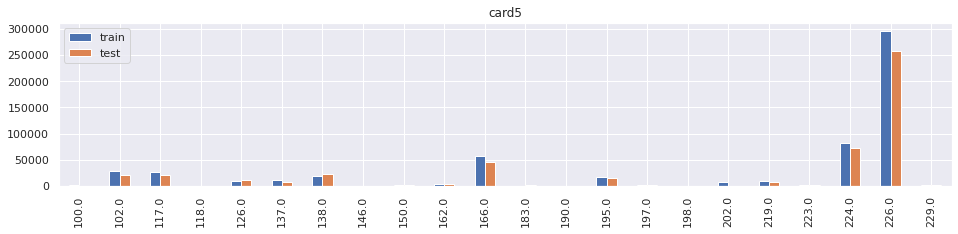

INFO:__main__:unique values num in train: 120


,226.0,224.0,166.0,138.0,117.0,102.0,195.0,126.0,219.0,137.0,162.0,229.0,223.0,197.0,150.0,183.0,118.0,190.0,146.0,198.0
card5,256991,71596,45790,22102,21120,20386,14951,11439,8402,7730,4512,2696,2524,1614,1212,989,695,652,588,542


INFO:__main__:unique values num in test: 103


,226.0,224.0,166.0,138.0,117.0,102.0,195.0,126.0,219.0,137.0,NaN,162.0,229.0,223.0,197.0,150.0,183.0,118.0,190.0,146.0,198.0,236.0,185.0,189.0,147.0,203.0,129.0,141.0,100.0,228.0,132.0,134.0,131.0,177.0,144.0,135.0,119.0,133.0,232.0,237.0,...,155.0,148.0,164.0,163.0,156.0,180.0,121.0,191.0,192.0,136.0,157.0,153.0,169.0,227.0,107.0,174.0,105.0,176.0,186.0,128.0,204.0,170.0,214.0,179.0,120.0,220.0,124.0,122.0,230.0,218.0,108.0,110.0,103.0,154.0,193.0,208.0,125.0,172.0,167.0,201.0
card5,0.507195,0.141301,0.090371,0.04362,0.041682,0.040234,0.029507,0.022576,0.016582,0.015256,0.008974,0.008905,0.005321,0.004981,0.003185,0.002392,0.001952,0.001372,0.001287,0.00116,0.00107,0.001066,0.000969,0.0009,0.000811,0.000764,0.000722,0.000697,0.000681,0.000497,0.000353,0.000324,0.00031,0.000278,0.000274,0.000266,0.000233,0.000231,0.000148,0.000114,...,0.000018,0.000018,0.000016,0.000014,0.00001,0.00001,0.00001,0.000008,0.000008,0.000008,0.000008,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


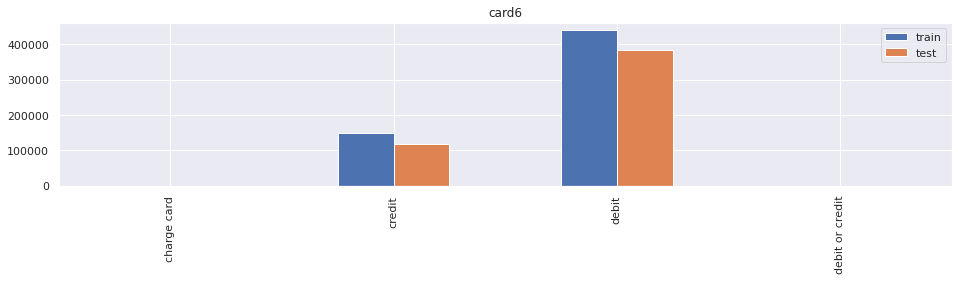

INFO:__main__:unique values num in train: 5


,debit,credit,charge card
card6,385021,118662,1


INFO:__main__:unique values num in test: 4


,debit,credit,NaN,charge card
card6,0.759873,0.23419,0.005935,0.000002


In [0]:
logger.info(f"does test dataset have card column? {df_test_org.columns.str.contains('card').any()}")
for name in df_train_org.columns[df_train_org.columns.str.contains("card")]:
    show_categorical_with_test(df_train_org, df_test_org, name)

### Categorical column: "M"

INFO:__main__:does test dataset have card column? True
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


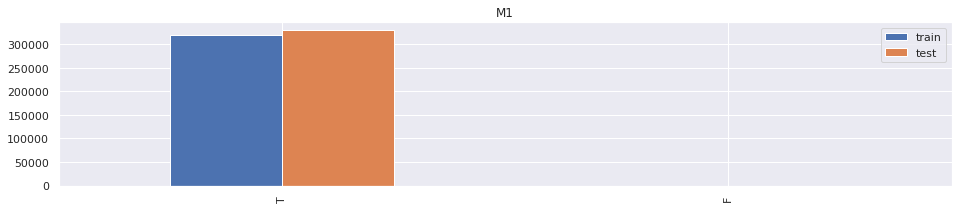

INFO:__main__:unique values num in train: 3


,T,F
M1,330021,31


INFO:__main__:unique values num in test: 3


,T,NaN,F
M1,0.651326,0.348613,0.000061


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


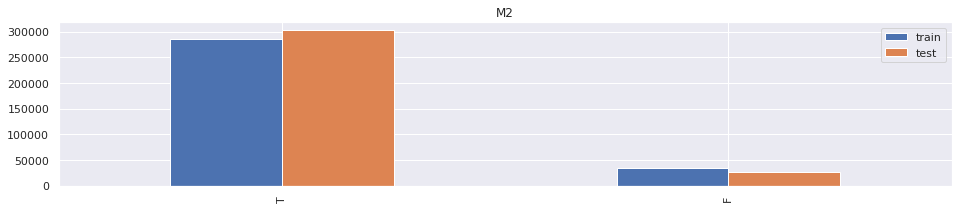

INFO:__main__:unique values num in train: 3


,T,F
M2,302855,27197


INFO:__main__:unique values num in test: 3


,T,NaN,F
M2,0.597711,0.348613,0.053676


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


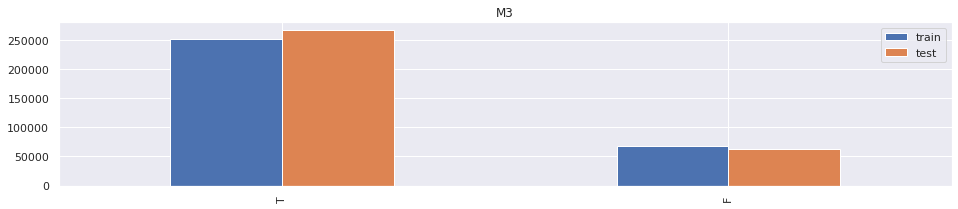

INFO:__main__:unique values num in train: 3


,T,F
M3,266513,63539


INFO:__main__:unique values num in test: 3


,T,NaN,F
M3,0.525987,0.348613,0.1254


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


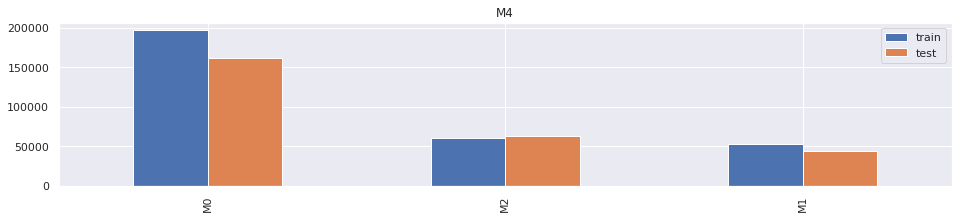

INFO:__main__:unique values num in train: 4


,M0,M2,M1
M4,161384,63082,44480


INFO:__main__:unique values num in test: 4


,NaN,M0,M2,M1
M4,0.469211,0.318506,0.124498,0.087785


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


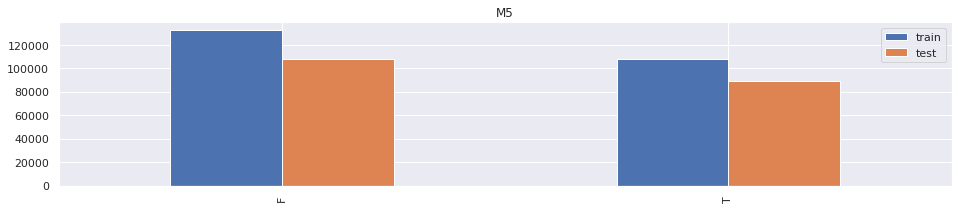

INFO:__main__:unique values num in train: 3


,F,T
M5,107664,89395


INFO:__main__:unique values num in test: 3


,NaN,F,T
M5,0.611086,0.212485,0.176429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


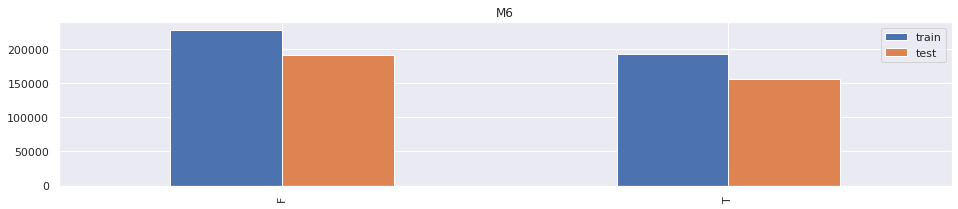

INFO:__main__:unique values num in train: 3


,F,T
M6,191577,156175


INFO:__main__:unique values num in test: 3


,F,NaN,T
M6,0.378094,0.31368,0.308225


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


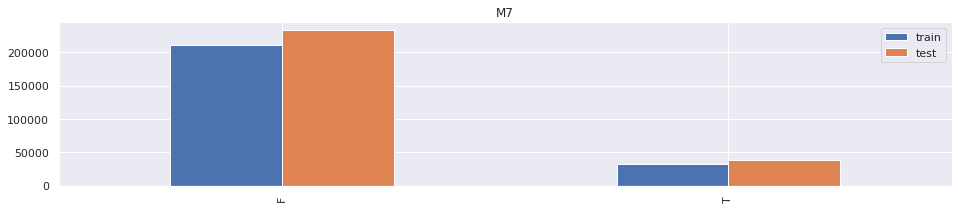

INFO:__main__:unique values num in train: 3


,F,T
M7,233230,38443


INFO:__main__:unique values num in test: 3


,NaN,F,T
M7,0.463829,0.4603,0.075871


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


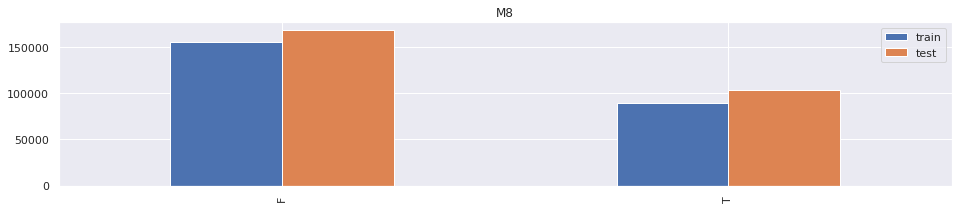

INFO:__main__:unique values num in train: 3


,F,T
M8,168399,103288


INFO:__main__:unique values num in test: 3


,NaN,F,T
M8,0.463801,0.33235,0.203848


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


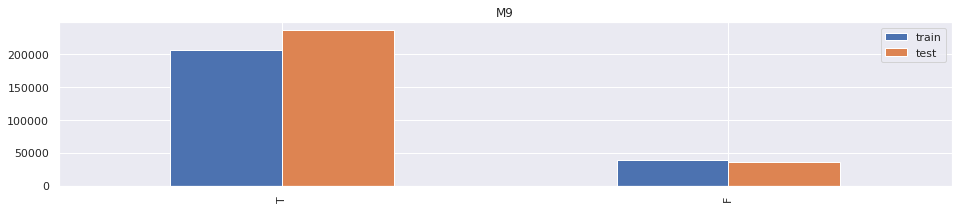

INFO:__main__:unique values num in train: 3


,T,F
M9,236279,35408


INFO:__main__:unique values num in test: 3


,T,NaN,F
M9,0.466318,0.463801,0.069881


In [0]:
logger.info(f"does test dataset have card column? {df_test_org.columns.str.contains('M').any()}")
for name in df_train_org.columns[df_train_org.columns.str.contains("M")]:
    show_categorical_with_test(df_train_org, df_test_org, name)

### Categorical column: "emaildomain"

INFO:__main__:does test dataset have card column? True
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


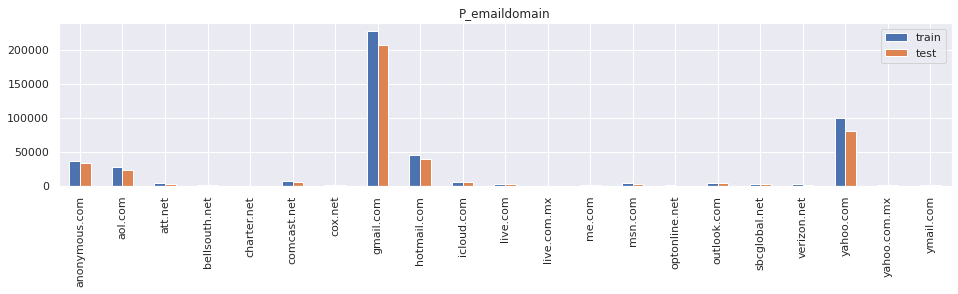

INFO:__main__:unique values num in train: 60


,gmail.com,yahoo.com,hotmail.com,anonymous.com,aol.com,comcast.net,icloud.com,outlook.com,att.net,msn.com,sbcglobal.net,live.com,verizon.net,ymail.com,bellsouth.net,yahoo.com.mx,cox.net,me.com,optonline.net,live.com.mx
P_emaildomain,207448,81850,40399,34064,24048,6586,6049,4838,3614,3388,2797,2679,2306,1679,1528,1284,1264,1191,926,721


INFO:__main__:unique values num in test: 61


,gmail.com,yahoo.com,NaN,hotmail.com,anonymous.com,aol.com,comcast.net,icloud.com,outlook.com,att.net,msn.com,sbcglobal.net,live.com,verizon.net,ymail.com,bellsouth.net,yahoo.com.mx,cox.net,me.com,optonline.net,live.com.mx,charter.net,mail.com,gmail,earthlink.net,rocketmail.com,mac.com,outlook.es,hotmail.fr,hotmail.es,frontier.com,web.de,roadrunner.com,juno.com,windstream.net,hotmail.co.uk,twc.com,embarqmail.com,frontiernet.net,yahoo.fr,centurylink.net,q.com,netzero.com,aim.com,cableone.net,gmx.de,suddenlink.net,cfl.rr.com,yahoo.es,netzero.net,sc.rr.com,prodigy.net.mx,hotmail.de,protonmail.com,ptd.net,yahoo.co.jp,yahoo.de,yahoo.co.uk,live.fr,servicios-ta.com,scranton.edu
P_emaildomain,0.409417,0.161538,0.136557,0.079731,0.067228,0.047461,0.012998,0.011938,0.009548,0.007133,0.006687,0.00552,0.005287,0.004551,0.003314,0.003016,0.002534,0.002495,0.002351,0.001828,0.001423,0.001237,0.001178,0.000981,0.000918,0.00087,0.000841,0.000839,0.000748,0.000635,0.00062,0.000549,0.000549,0.000497,0.000487,0.000438,0.000412,0.000403,0.000399,0.000397,0.000357,0.000341,0.00031,0.000302,0.0003,0.000294,0.000292,0.000288,0.000272,0.000243,0.000223,0.000189,0.000172,0.000164,0.000142,0.000136,0.000124,0.000107,0.000099,0.000089,0.000004


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


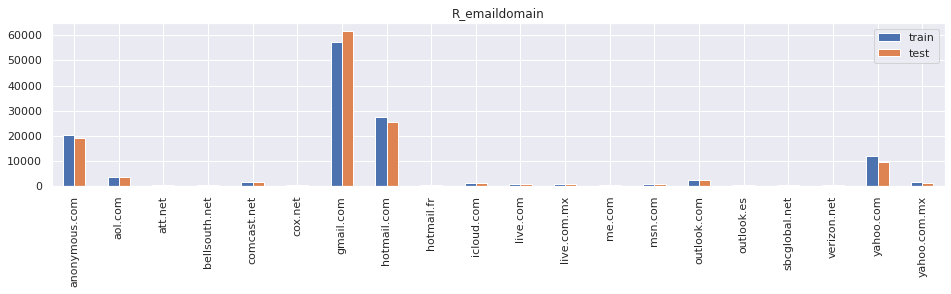

INFO:__main__:unique values num in train: 61


,gmail.com,hotmail.com,anonymous.com,yahoo.com,aol.com,outlook.com,comcast.net,icloud.com,yahoo.com.mx,msn.com,live.com.mx,live.com,sbcglobal.net,verizon.net,me.com,att.net,outlook.es,cox.net,hotmail.fr,bellsouth.net
R_emaildomain,61738,25657,19115,9563,3538,2504,1701,1422,1235,846,710,682,611,582,539,440,420,395,374,373


INFO:__main__:unique values num in test: 61


,NaN,gmail.com,hotmail.com,anonymous.com,yahoo.com,aol.com,outlook.com,comcast.net,icloud.com,yahoo.com.mx,msn.com,live.com.mx,live.com,sbcglobal.net,verizon.net,me.com,att.net,outlook.es,cox.net,hotmail.fr,bellsouth.net,hotmail.es,web.de,mail.com,hotmail.co.uk,mac.com,ymail.com,yahoo.fr,optonline.net,gmx.de,charter.net,gmail,prodigy.net.mx,earthlink.net,hotmail.de,embarqmail.com,yahoo.co.jp,yahoo.es,yahoo.de,juno.com,frontier.com,windstream.net,rocketmail.com,live.fr,roadrunner.com,servicios-ta.com,yahoo.co.uk,ptd.net,aim.com,protonmail.com,twc.com,suddenlink.net,frontiernet.net,cfl.rr.com,q.com,cableone.net,centurylink.net,netzero.net,netzero.com,scranton.edu,sc.rr.com
R_emaildomain,0.731848,0.121845,0.050636,0.037725,0.018873,0.006983,0.004942,0.003357,0.002806,0.002437,0.00167,0.001401,0.001346,0.001206,0.001149,0.001064,0.000868,0.000829,0.00078,0.000738,0.000736,0.000598,0.000547,0.000432,0.000418,0.000418,0.000391,0.000351,0.000322,0.000296,0.000268,0.000199,0.000189,0.00018,0.000174,0.000142,0.00014,0.000132,0.000126,0.000114,0.000114,0.000112,0.000112,0.000099,0.000095,0.000089,0.000085,0.000085,0.000081,0.000067,0.000063,0.000059,0.000047,0.000039,0.000039,0.000037,0.000032,0.00002,0.00002,0.000012,0.000012


In [0]:
logger.info(f"does test dataset have card column? {df_test_org.columns.str.contains('emaildomain').any()}")
for name in df_train_org.columns[df_train_org.columns.str.contains("emaildomain")]:
    show_categorical_with_test(df_train_org, df_test_org, name)

### Categorical column: "addr"

INFO:__main__:does test dataset have card column? True
INFO:__main__:addr1 has many unique values. number of unique values is 332.  skip.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


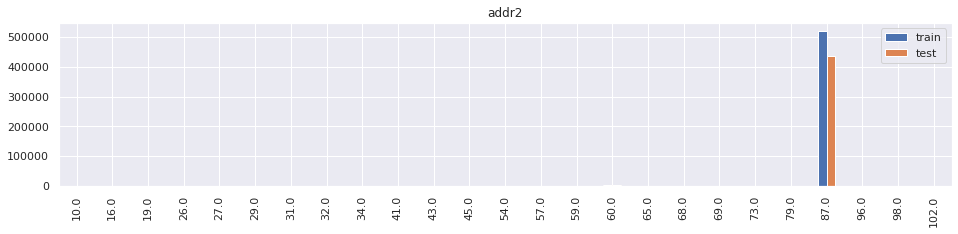

INFO:__main__:unique values num in train: 75


,87.0,60.0,96.0,32.0,65.0,31.0,69.0,19.0,16.0,73.0,57.0,43.0,98.0,27.0,34.0,102.0,54.0,79.0,41.0,45.0
addr2,435934,4041,608,61,49,36,27,23,22,21,19,18,15,14,11,10,10,8,8,7


INFO:__main__:unique values num in test: 73


,87.0,NaN,60.0,96.0,32.0,65.0,31.0,69.0,19.0,16.0,73.0,57.0,43.0,98.0,27.0,34.0,54.0,102.0,41.0,79.0,26.0,45.0,36.0,101.0,100.0,38.0,61.0,40.0,24.0,72.0,48.0,62.0,30.0,88.0,28.0,17.0,95.0,56.0,12.0,29.0,52.0,53.0,10.0,67.0,68.0,71.0,81.0,59.0,84.0,74.0,66.0,44.0,94.0,93.0,90.0,46.0,58.0,51.0,33.0,77.0,47.0,86.0,37.0,11.0,78.0,64.0,13.0,80.0,99.0,85.0,42.0,18.0,91.0
addr2,0.860355,0.129485,0.007975,0.0012,0.00012,0.000097,0.000071,0.000053,0.000045,0.000043,0.000041,0.000037,0.000036,0.00003,0.000028,0.000022,0.00002,0.00002,0.000016,0.000016,0.000014,0.000014,0.000014,0.00001,0.00001,0.00001,0.00001,0.00001,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


In [0]:
logger.info(f"does test dataset have card column? {df_test_org.columns.str.contains('addr').any()}")
for name in df_train_org.columns[df_train_org.columns.str.contains("addr")]:
    show_categorical_with_test(df_train_org, df_test_org, name)

### Train and Test distribution of transaction DT

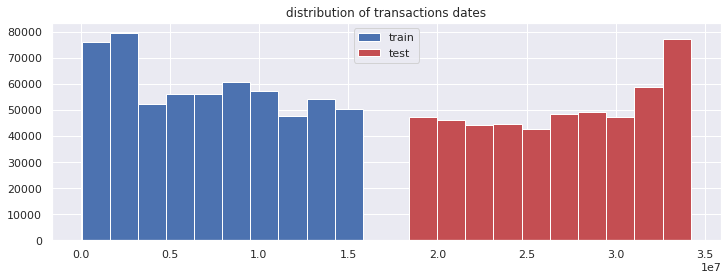

In [0]:
def show_transaction_dt(df_train: pd.DataFrame, df_test: pd.DataFrame) -> None:
    name = "TransactionDT"
    plt.figure(figsize=(12, 4))
    plt.hist(df_train[name], color="b", label="train")
    plt.hist(df_test[name], color="r", label="test")
    plt.legend()
    plt.title(f"distribution of transactions dates")
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


show_transaction_dt(df_train_org, df_test_org)

## Feature Engineering

In [0]:
def create_feature(df_source: pd.DataFrame) -> pd.DataFrame:
    def group_div(target: pd.DataFrame, name: str, group: str, method: str) -> pd.Series:
        denom = target.groupby([group])[name].transform(method)
        return target[name] / denom

    df = df_source.copy()

    df["TransactionAmt_to_mean_card1"] = group_div(df_source, "TransactionAmt", "card1", "mean")
    df["TransactionAmt_to_std_card1"] = group_div(df_source, "TransactionAmt", "card1", "std")
    df["TransactionAmt_to_mean_card4"] = group_div(df_source, "TransactionAmt", "card4", "mean")
    df["TransactionAmt_to_std_card4"] = group_div(df_source, "TransactionAmt", "card4", "std")

    df["id_02_to_mean_card1"] = group_div(df_source, "id_02", "card1", "mean")
    df["id_02_to_std_card1"] = group_div(df_source, "id_02", "card1", "std")
    df["id_02_to_mean_card4"] = group_div(df_source, "id_02", "card4", "mean")
    df["id_02_to_std_card4"] = group_div(df_source, "id_02", "card4", "std")

    df["D15_to_mean_card1"] = group_div(df_source, "D15", "card1", "mean")
    df["D15_to_std_card1"] = group_div(df_source, "D15", "card1", "std")
    df["D15_to_mean_card4"] = group_div(df_source, "D15", "card4", "mean")
    df["D15_to_std_card4"] = group_div(df_source, "D15", "card4", "std")

    df["D15_to_mean_addr1"] = group_div(df_source, "D15", "addr1", "mean")
    df["D15_to_std_addr1"] = group_div(df_source, "D15", "addr1", "std")
    df["D15_to_mean_addr2"] = group_div(df_source, "D15", "addr2", "mean")
    df["D15_to_std_addr2"] = group_div(df_source, "D15", "addr2", "std")

    df[["P_emaildomain_1", "P_emaildomain_2", "P_emaildomain_3"]] = df_source["P_emaildomain"].str.split(".", expand=True)
    df[["R_emaildomain_1", "R_emaildomain_2", "R_emaildomain_3"]] = df_source["R_emaildomain"].str.split(".", expand=True)

    return df

In [0]:
%time df_train_fe = create_feature(df_train_org)

CPU times: user 4.56 s, sys: 103 ms, total: 4.66 s
Wall time: 4.64 s


In [0]:
display.display(df_train_fe.head())
display.display(df_train_fe.tail())
logger.info(df_train_fe.info())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.194640,0.184566,0.257761,0.170233,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123777,0.062995,0.219054,0.114212,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.608150,0.589241,0.443070,0.258544,NaN,NaN,NaN,NaN,2.518583,1.851016,1.865915,1.541448,1.611525,1.486472,1.721392,1.522249,outlook,com,None,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.405133,0.259447,0.377679,0.196917,NaN,NaN,NaN,NaN,0.550272,0.520531,0.720057,0.558392,0.686169,0.576638,0.606586,0.536412,yahoo,com,None,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0.515612,0.882933,0.377679,0.196917,0.764773,1.753301,0.373295,0.425884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gmail,com,None,NaN,NaN,NaN


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.505177,0.363843,0.367973,0.214723,NaN,NaN,NaN,NaN,0.307857,0.269218,0.331718,0.274035,0.330520,0.276139,0.306025,0.270622,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.163195,0.402579,0.298366,0.155564,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258474,0.203942,0.233783,0.121891,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,gmail,com,None,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.953051,0.662777,0.883768,0.460785,NaN,NaN,NaN,NaN,0.108422,0.106296,0.142714,0.110672,0.127389,0.109010,0.120224,0.106316,aol,com,None,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,credit,299.0,87.0,NaN,NaN,gmail.com,NaN,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333976,0.899892,2.114622,1.102536,NaN,NaN,NaN,NaN,0.008034,0.005348,0.006487,0.005031,0.005946,0.004884,0.005465,0.004833,gmail,com,None,NaN,NaN,NaN


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 456 entries, TransactionID to R_emaildomain_3
dtypes: float64(415), int64(4), object(37)
memory usage: 2.0+ GB


In [0]:
%time df_test_fe = create_feature(df_test_org)

CPU times: user 4.01 s, sys: 40.7 ms, total: 4.05 s
Wall time: 4.03 s


In [0]:
display.display(df_test_fe.head())
display.display(df_test_fe.tail())
logger.info(df_test_fe.info())

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.339332,0.260350,0.237290,0.129831,NaN,NaN,NaN,NaN,1.066067,1.665603,1.925444,1.502141,1.557394,1.450810,1.760048,1.477451,gmail,com,None,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333494,0.134271,0.363919,0.199114,NaN,NaN,NaN,NaN,2.155230,2.047675,2.984674,2.328502,3.033737,2.300422,2.728290,2.290230,aol,com,None,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.485504,1.895771,1.270002,0.694869,NaN,NaN,NaN,NaN,0.279881,0.339451,0.456646,0.356253,0.457103,0.351657,0.417420,0.350398,hotmail,com,None,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.969653,1.913954,2.116298,1.157912,NaN,NaN,NaN,NaN,1.578683,1.130023,1.139260,0.888797,1.020278,0.901970,1.041398,0.874189,gmail,com,None,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.567364,0.310151,0.517674,0.277467,NaN,NaN,NaN,NaN,0.085873,0.075361,0.109654,0.083425,0.098978,0.080181,0.094673,0.079472,gmail,com,None,NaN,NaN,NaN


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4,id_02_to_mean_card1,id_02_to_std_card1,id_02_to_mean_card4,id_02_to_std_card4,D15_to_mean_card1,D15_to_std_card1,D15_to_mean_card4,D15_to_std_card4,D15_to_mean_addr1,D15_to_std_addr1,D15_to_mean_addr2,D15_to_std_addr2,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.771274,2.786783,0.721308,0.386612,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,gmail,com,None,gmail,com,None
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23,0.360082,0.369440,0.092739,0.049707,0.872946,1.422157,1.220024,1.403943,0.24353,0.104885,0.079748,0.060673,NaN,NaN,NaN,NaN,hotmail,com,None,hotmail,com,None
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424053,0.280924,0.363919,0.199114,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,hotmail,com,None,NaN,NaN,NaN
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.315186,2.640523,1.538928,0.824846,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,hotmail,com,None,NaN,NaN,NaN
506690,4170239,34214345,24.346,C,5713,168.0,144.0,visa,147.0,credit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,29.958332,0.958333,0.0,...,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,samsung browser 8.2,NaN,NaN,NaN,F,F,T,F,mobile,SAMSUNG,0.162994,0.091806,0.180816,0.098931,3.020494,3.254803,3.673150,3.805817,0.00000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,hotmail,com,None,hotmail,com,None


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 455 entries, TransactionID to R_emaildomain_3
dtypes: float64(415), int64(3), object(37)
memory usage: 1.7+ GB


## Prepare data for modeling

In [0]:
def many_null_cols(df: pd.DataFrame) -> t.List[str]:
    threshold = 0.9
    return [
        name for name in df.columns
        if df[name].isnull().sum() / df.shape[0] > threshold
    ]


def big_top_value_cols(df: pd.DataFrame) -> t.List[str]:
    threshold = 0.9
    return [
        name for name in df.columns
        if df[name].value_counts(dropna=False, normalize=True).values[0] > threshold
    ]


def drop_columns(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:


    many_null_cols_train = many_null_cols(df_train)
    many_null_cols_test = many_null_cols(df_test)
    big_top_value_train = big_top_value_cols(df_train)
    big_top_value_test = big_top_value_cols(df_test)
    drop_cols = list(set(
        many_null_cols_train
        + many_null_cols_test
        + big_top_value_train
        + big_top_value_test
    ))
    drop_cols.remove("isFraud")

    logger.info(f"drop num: {len(drop_cols)}")
    logger.info(f"drop columns: {pprint.pformat(drop_cols)}")

    return (
        df_train.drop(drop_cols, axis=1),
        df_test.drop(drop_cols, axis=1)
    )


%time df_train_droped, df_test_droped = drop_columns(df_train_fe, df_test_fe)

INFO:__main__:drop num: 84
INFO:__main__:drop columns: ['V109',
 'V55',
 'V309',
 'V122',
 'V298',
 'V77',
 'V305',
 'V281',
 'V117',
 'V137',
 'V88',
 'V299',
 'V120',
 'V320',
 'V290',
 'id_21',
 'V134',
 'V106',
 'id_23',
 'V101',
 'V27',
 'V107',
 'V136',
 'V300',
 'id_25',
 'V318',
 'V66',
 'id_18',
 'V311',
 'V110',
 'dist2',
 'D7',
 'V319',
 'P_emaildomain_3',
 'V98',
 'V116',
 'id_07',
 'V129',
 'V25',
 'V286',
 'id_24',
 'V316',
 'V118',
 'V301',
 'V121',
 'V125',
 'V102',
 'V103',
 'V14',
 'id_08',
 'id_26',
 'V89',
 'V113',
 'V86',
 'V135',
 'C3',
 'V123',
 'V124',
 'V297',
 'V28',
 'V115',
 'R_emaildomain_3',
 'V67',
 'V132',
 'V65',
 'V108',
 'V321',
 'V133',
 'V284',
 'V296',
 'V295',
 'V105',
 'V293',
 'V68',
 'V24',
 'V119',
 'id_27',
 'V112',
 'id_22',
 'V26',
 'V111',
 'V104',
 'V114',
 'V23']


CPU times: user 14.8 s, sys: 128 ms, total: 14.9 s
Wall time: 14.9 s


In [0]:
def label_encoding(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
) -> t.Tuple[pd.DataFrame, pd.DataFrame]:
    categorical_cols = [
        *[f"id_{num}" for num in range(12, 39)],
        *[f"card{num}" for num in range(1, 7)],
        *[f"addr{num}" for num in range(1, 3)],
        *[f"M{num}" for num in range(1, 10)],
        'P_emaildomain',
        *[f"P_emaildomain_{num}" for num in range(1, 4)],
        'R_emaildomain',
        *[f"R_emaildomain_{num}" for num in range(1, 4)],
        'DeviceType',
        'DeviceInfo',
        'ProductCD',
    ]
    categorical_cols = [
        name for name in categorical_cols
        if name in df_train.columns
    ]

    df_train_enc = df_train.copy()
    df_test_enc = df_test.copy()
    for name in categorical_cols:
        le = preprocessing.LabelEncoder()
        train_list = df_train[name].astype(str).to_list()
        test_list = list()
        if name in df_test.columns:
            test_list = df_test[name].astype(str).to_list()
        le.fit(train_list + test_list)

        df_train_enc[name] = le.transform(df_train[name].astype(str).to_list())
        if name in df_test.columns:
            df_test_enc[name] = le.transform(df_test[name].astype(str).to_list())

    return df_train_enc, df_test_enc


%time df_train_encoded, df_test_encoded = label_encoding(df_train_droped, df_test_droped)

CPU times: user 1min 6s, sys: 2.28 s, total: 1min 8s
Wall time: 1min 8s


In [0]:
def clean_inf_nan(df: pd.DataFrame) -> pd.DataFrame:
    return df.replace([np.inf, -np.inf], np.nan)


def create_train_test_set(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
) -> None:
    train_sorted = df_train.sort_values("TransactionDT")
    train_x = train_sorted.drop(["isFraud", "TransactionDT", "TransactionID"], axis=1)
    train_x = clean_inf_nan(train_x)
    train_y = train_sorted["isFraud"]

    test_x = df_test.drop(["TransactionDT", "TransactionID"], axis=1)
    test_x = clean_inf_nan(test_x)
    test_index = df_test[["TransactionDT", "TransactionID"]]

    return train_x, train_y, test_x, test_index


%time df_train_x, df_train_y, df_test_x, df_test_index = \
    create_train_test_set(df_train_encoded, df_test_encoded)

CPU times: user 3.74 s, sys: 2.09 s, total: 5.84 s
Wall time: 5.86 s


In [0]:
# del df_train_fe
# del df_test_fe
# del df_train_droped
# del df_test_droped
# del df_train_encoded
# del df_test_encoded

gc.collect()

302

## LGBM

### Training

In [0]:
def train_lightgbm(df_x: pd.DataFrame, df_y: pd.DataFrame) -> t.Dict:
    n_fold = 5
    folds = model_selection.TimeSeriesSplit(n_splits=n_fold)
    params = {
        "num_leaves": 256,
        "min_child_samples": 79,
        "objective": "binary",
        "max_depth": 13,
        "learning_rate": 0.03,
        "boosting_type": "gbdt",
        "subsample_freq": 3,
        "subsample": 0.9,
        "bagging_seed": 11,
        "metric": "auc",
        "verbosity": -1,
        "reg_alpha": 0.3,
        "reg_lambda": 0.3,
        "colsample_bytree": 0.9,
    }
    # model_type = "lgb"
    # eval_metric = "auc"
    verbose = 500
    early_stopping_rounds = 200
    n_estimators = 5000
    averaging = "usual"
    n_jobs = -1

    oof = np.zeros((len(df_x), 1))
    scores = list()
    models = list()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(df_x)):
        logger.info(f"Fold {fold_n + 1} started at {time.ctime()}")

        x_train, x_valid = df_x.iloc[train_index], df_x.iloc[valid_index]
        y_train, y_valid = df_y.iloc[train_index], df_y.iloc[valid_index]

        model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs=n_jobs)
        model.fit(
            x_train,
            y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            verbose=verbose,
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred_valid = model.predict_proba(x_valid)[:, 1]

        models.append(model)
        oof[valid_index] = y_pred_valid.reshape(-1, 1)
        scores.append(metrics.roc_auc_score(y_valid, y_pred_valid))

    logger.info(f"CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}")

    result = dict(models=models, oof=oof, scores=scores)
    return result


%time result = train_lightgbm(df_train_x, df_train_y)

INFO:__main__:Fold 1 started at Sun Apr 12 03:01:42 2020


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[279]	training's auc: 0.999459	valid_1's auc: 0.900296


INFO:__main__:Fold 2 started at Sun Apr 12 03:02:56 2020


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[204]	training's auc: 0.993176	valid_1's auc: 0.917584


INFO:__main__:Fold 3 started at Sun Apr 12 03:05:00 2020


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[238]	training's auc: 0.991589	valid_1's auc: 0.906785


INFO:__main__:Fold 4 started at Sun Apr 12 03:08:15 2020


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[284]	training's auc: 0.989232	valid_1's auc: 0.928847


INFO:__main__:Fold 5 started at Sun Apr 12 03:12:54 2020


Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.994293	valid_1's auc: 0.927254
Early stopping, best iteration is:
[392]	training's auc: 0.99153	valid_1's auc: 0.928824


INFO:__main__:CV mean score: 0.9165, std: 0.0115


CPU times: user 1h 10min 15s, sys: 12.2 s, total: 1h 10min 28s
Wall time: 18min 3s


### feature importance

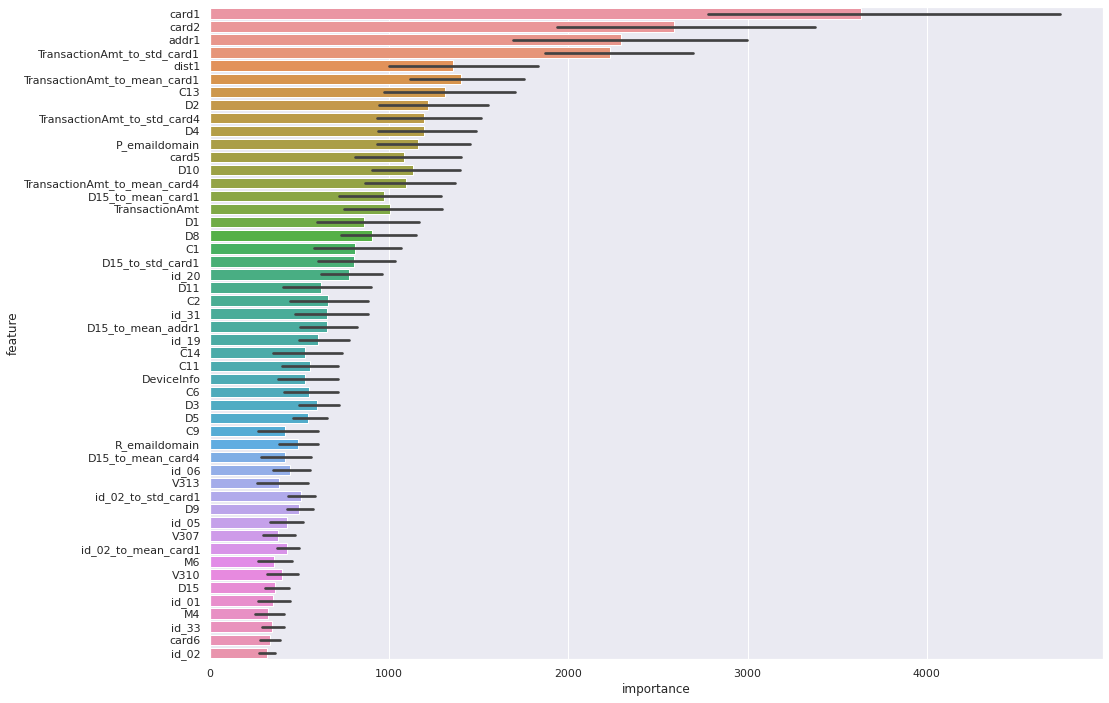

In [0]:
def show_feature_importance(
    models: t.List[lgb.LGBMModel],
    feature_columns: t.List[str]
) -> None:
    df = pd.DataFrame()
    for fold_n, model in enumerate(models):
        df_model = pd.DataFrame()
        df_model["feature"] = feature_columns
        df_model["importance"] = model.feature_importances_
        df_model["fold"] = fold_n
        df = pd.concat([df, df_model], axis=0)

    top_n = 50
    cols = df[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False
    )[:top_n].index
    best_features = df.loc[df["feature"].isin(cols)]
    best_features = best_features.sort_values(by="importance", ascending=False)

    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=best_features)
    plt.show()
    plt.cla()
    plt.clf()
    plt.close()


show_feature_importance(result["models"], df_train_x.columns.to_list())

### Prediction

In [0]:
def expand_test(df_train: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
    cols_train = df_train.columns.to_list()
    cols_test = df_test.columns.to_list()

    lack_list = list(set(cols_train) - set(cols_test))
    logger.info(pprint.pformat(lack_list))

    df = df_test.copy()
    for name in lack_list:
        df[name] = np.nan
    df = df[cols_train]

    return df


# df_test_x_expand = expand_test(df_train_x, df_test_x)

In [0]:
def show_prediction_result(
    models: t.List[lgb.LGBMModel],
    df_test: pd.DataFrame,
) -> None:
    prediction = np.zeros((len(df_test), 1))
    for model in tqdm.tqdm(models):
        pred = model.predict_proba(df_test)
        prediction += pred[:, 1].reshape(-1, 1)
    prediction /= len(models)

    return prediction


%time pred_test = show_prediction_result(result["models"], df_test_x)


CPU times: user 3min 50s, sys: 326 ms, total: 3min 50s
Wall time: 1min 7s


In [0]:
def create_sub(df_sub: pd.DataFrame, prediction: np.ndarray) -> pd.DataFrame:
    sub = df_sub.copy()
    sub["isFraud"] = prediction

    return sub


df_sub_pred = create_sub(df_sub_org, pred_test)

In [0]:
display.display(df_sub_pred.head())
display.display(df_sub_pred.tail())
logger.info(df_sub_pred.info())

,TransactionID,isFraud
0,3663549,0.002266
1,3663550,0.006218
2,3663551,0.006596
3,3663552,0.001953
4,3663553,0.003275


,TransactionID,isFraud
506686,4170235,0.010825
506687,4170236,0.009554
506688,4170237,0.007747
506689,4170238,0.010855
506690,4170239,0.005952


INFO:__main__:None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int64  
 1   isFraud        506691 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.7 MB


## Submission

In [0]:
def submit(df_sub: pd.DataFrame, outdir: pathlib.Path, name: str, message: str) -> None:
    outpath = outdir.joinpath("submission.csv")
    df_sub.to_csv(outpath, index=False)
    !kaggle competitions submit "$name" -f "$outpath" -m "$message"


# submit(df_sub_pred, processed_dir, competition_name, "first test.")

100% 14.0M/14.0M [00:01<00:00, 7.67MB/s]
Successfully submitted to IEEE-CIS Fraud Detection